# Vector integration problem

In [1]:
import sympy as sym
import numpy as np

----
## Example: magnetic field induced by loop current

### Vector potential setup

In [2]:
x, y, z, p = sym.symbols(r"x, y, z, \phi", real=True)
r = sym.Symbol('r', positive=True)

x_s, y_s, z_s, p_s = sym.symbols(r"x', y', z', \phi'", real=True)
r_s = sym.Symbol("r'", positive=True)

e_x = sym.symbols(r'\hat{\mathbf{e}}_x')
e_y = sym.symbols(r'\hat{\mathbf{e}}_y')
e_p = sym.symbols(r'\hat{\mathbf{e}}_\phi')
es_p = sym.symbols(r"\hat{\mathbf{e}}'_\phi")

j_vec, A_vec, B_vec = sym.symbols(r"\mathbf{j}, \mathbf{A}, \mathbf{B}")

map_cart2cyl = {
    x: r*sym.cos(p), y: r*sym.sin(p), z: z,
    x_s: r_s*sym.cos(p_s), y_s: r_s*sym.sin(p_s), z_s: z_s,
}
transform_cyl2cart = {
    e_p: -sym.sin(p)*e_x + sym.cos(p)*e_y,
    es_p: -sym.sin(p_s)*e_x + sym.cos(p_s)*e_y,
}

I_p = sym.Function(r'I_\phi')(p_s)

display(sym.Eq(j_vec, I_p*sym.DiracDelta(z_s)*sym.DiracDelta(r_s-1)*es_p))

Eq(\mathbf{j}, \hat{\mathbf{e}}'_\phi*I_\phi(\phi')*DiracDelta(z')*DiracDelta(r' - 1))

In [3]:
int_ker_cart = 1/sym.sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)
int_ker_cyl = int_ker_cart.subs(map_cart2cyl).simplify()

A_expr = sym.Integral(I_p*sym.DiracDelta(z_s)*sym.DiracDelta(r_s-1)*es_p*int_ker_cyl, (r_s, 0, sym.oo), (p_s, 0, 2*sym.pi), (z_s, -sym.oo, sym.oo))
display(sym.Eq(A_vec, A_expr))

Eq(\mathbf{A}, Integral(\hat{\mathbf{e}}'_\phi*I_\phi(\phi')*DiracDelta(z')*DiracDelta(r' - 1)/sqrt(r**2 - 2*r*r'*cos(\phi - \phi') + r'**2 + z**2 - 2*z*z' + z'**2), (r', 0, oo), (\phi', 0, 2*pi), (z', -oo, oo)))

In [4]:
A_expr_cart = A_expr.subs(transform_cyl2cart).doit()
A_terms = [A_term.simplify() for A_term in A_expr_cart.args]
A_expr_cart = sym.Add(*A_terms)
display(sym.Eq(A_vec, A_expr_cart))

Eq(\mathbf{A}, -\hat{\mathbf{e}}_x*Integral(I_\phi(\phi')*sin(\phi')/sqrt(r**2 - 2*r*cos(\phi - \phi') + z**2 + 1), (\phi', 0, 2*pi)) + \hat{\mathbf{e}}_y*Integral(I_\phi(\phi')*cos(\phi')/sqrt(r**2 - 2*r*cos(\phi - \phi') + z**2 + 1), (\phi', 0, 2*pi)))

### Configure current loop

In [85]:
params = {
    # I_p: 1,
    I_p: sym.sin(p_s + sym.pi/4)
}

A_cart = A_expr_cart.subs(params)
display(sym.Eq(A_vec, A_cart))

Eq(\mathbf{A}, -\hat{\mathbf{e}}_x*Integral(sin(\phi')*sin(\phi' + pi/4)/sqrt(r**2 - 2*r*cos(\phi - \phi') + z**2 + 1), (\phi', 0, 2*pi)) + \hat{\mathbf{e}}_y*Integral(sin(\phi' + pi/4)*cos(\phi')/sqrt(r**2 - 2*r*cos(\phi - \phi') + z**2 + 1), (\phi', 0, 2*pi)))

### Calculate at a given point

In [86]:
position = {
    r: 2,
    p: 0,
    z: 0
}

A_val_cart = A_cart.subs(position).doit()

x_comp_val = A_val_cart.coeff(e_x).evalf(7, chop=1e-7)
y_comp_val = A_val_cart.coeff(e_y).evalf(7, chop=1e-7)
A_val_evalf = x_comp_val*e_x + y_comp_val*e_y

display(sym.Eq(A_vec, A_val_cart))
display(sym.Eq(A_vec, A_val_evalf))

Eq(\mathbf{A}, -\hat{\mathbf{e}}_x*Integral(sin(\phi')*sin(\phi' + pi/4)/sqrt(5 - 4*cos(\phi')), (\phi', 0, 2*pi)) + \hat{\mathbf{e}}_y*Integral(sin(\phi' + pi/4)*cos(\phi')/sqrt(5 - 4*cos(\phi')), (\phi', 0, 2*pi)))

Eq(\mathbf{A}, -1.074831*\hat{\mathbf{e}}_x + 1.30918*\hat{\mathbf{e}}_y)

### Calculate field distribution

In [87]:
x_comp_expr = A_expr_cart.coeff(e_x)
y_comp_expr = A_expr_cart.coeff(e_y)
x_integral, y_integral = -x_comp_expr, y_comp_expr

Numerical quadrature

In [88]:
r_grid = np.linspace(1.5, 5, num=11)
p_grid = np.linspace(0, 2*np.pi, num=41)[:-1]
z_cst = 0.

ps_quad = np.linspace(0, 2*np.pi, num=101)[:-1]
wt_quad = 2*np.pi/ps_quad.size

rr, pp, pp_s_quad = np.meshgrid(r_grid, p_grid, ps_quad, indexing='ij')

x_integral_f = sym.lambdify([r, p, z, p_s], x_integral.args[0].subs(params), modules=['numpy', 'scipy'])
y_integral_f = sym.lambdify([r, p, z, p_s], y_integral.args[0].subs(params), modules=['numpy', 'scipy'])
x_int_val = np.sum(x_integral_f(rr, pp, z_cst, pp_s_quad)*wt_quad, axis=-1)
y_int_val = np.sum(y_integral_f(rr, pp, z_cst, pp_s_quad)*wt_quad, axis=-1)

Plotting

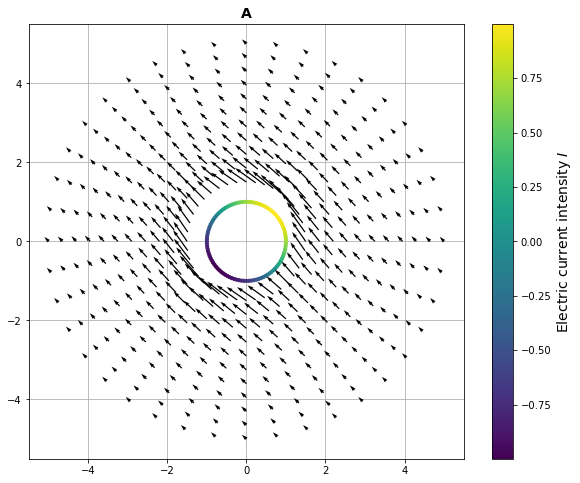

In [90]:
import matplotlib.pyplot as plt

XX, YY = rr[..., 0]*np.cos(pp[..., 0]), rr[..., 0]*np.sin(pp[..., 0])

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.scatter(np.cos(ps_quad), np.sin(ps_quad), 10, sym.lambdify([p_s], params[I_p], modules=['numpy', 'scipy'])(ps_quad)*np.ones_like(ps_quad), cmap='viridis', zorder=4)
ax.quiver(XX, YY, -x_int_val, y_int_val, zorder=4)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Electric current intensity $I$', fontsize=14)
ax.grid()
ax.set_aspect('equal', 'box')
ax.set_title(r'$\mathbf{A}$', fontsize=14)

plt.show()

In [94]:
t, k, nu = sym.symbols(r'\theta, k, \nu', real=True)
n = sym.symbols('n', integer=True)

In [95]:
sym.besselj(nu, k*r)

besselj(\nu, k*r)

In [ ]:
f_func = s